# Car Seats
- A simulated data set containing sales of child car seats at 400 different stores.
- There are 400 rows.
- There are 11 variables:
    - Sales: Unit sales (in thousands) at each location
    - CompPrice: Price charged by competitor at each location
    - Income: Community income level (in thousands of dollars)
    - Advertising: Local advertising budget for company at each location (in thousands of dollars)
    - Population: Population size in region (in thousands)
    - Price: Price company charges for car seats at each site ("site" refers to an individual store location)
    - ShelveLoc: A factor with levels Bad, Good and Medium indicating the quality of the shelving location for the car seats at each site
        - Bad: Indicates a poor shelving location, which might result in lower visibility and potentially fewer sales.
    - Age: Average age of the local population
    - Education: Education level at each location
    - Urban: A factor with levels No and Yes to indicate whether the store is in an urban or rural location
    - US: A factor with levels No and Yes to indicate whether the store is in the US or not

# Load Packages and Data

In [1]:
%%capture
pip install ISLP

In [2]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS
from ISLP.bart import BART

In [3]:
Carseats = load_data('Carseats')
Carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [4]:
Carseats.describe().round(1)

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education
count,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0
mean,7.5,125.0,68.7,6.6,264.8,115.8,53.3,13.9
std,2.8,15.3,28.0,6.7,147.4,23.7,16.2,2.6
min,0.0,77.0,21.0,0.0,10.0,24.0,25.0,10.0
25%,5.4,115.0,42.8,0.0,139.0,100.0,39.8,12.0
50%,7.5,125.0,69.0,5.0,272.0,117.0,54.5,14.0
75%,9.3,135.0,91.0,12.0,398.5,131.0,66.0,16.0
max,16.3,175.0,120.0,29.0,509.0,191.0,80.0,18.0


# Fitting Classification Trees

- We start by analyzing the `Carseats` data set with classification trees.
- Since `Sales` is a continuous variable, we convert it to a binary variable named `High` using the `where()` function. `High` is set to `Yes` if `Sales` exceeds 8, and `No` otherwise.

In [3]:
High = np.where(Carseats.Sales > 8, "Yes", "No")

- Next, we use `DecisionTreeClassifier()` to build a classification tree that predicts `High` based on all variables except `Sales`.
- This requires creating a model matrix, similar to what we did for regression models.

In [4]:
model = MS(Carseats.columns.drop('Sales'), intercept=False)
D = model.fit_transform(Carseats)
feature_names = list(D.columns)
X = np.asarray(D)

- We converted the data frame `D` into an array `X` for our analysis and also need `feature_names` for labeling our plots later.
- To configure the classifier, we specify options:
    - `max_depth` (the maximum tree depth)
    - `min_samples_split` (minimum observations required in a node to split)
    - `criterion` (choice between Gini or cross-entropy for splits).
    - We also set `random_state` to ensure reproducibility, as ties in the split criterion are resolved randomly.

In [5]:
clf = DTC(criterion='entropy', max_depth=3, random_state=0)        
clf.fit(X, High)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

- In the book, we explained how to represent qualitative features in linear regression using dummy variables (one-hot encoding). 
- While decision trees can naturally handle qualitative features without dummy variables, as each split can partition the levels into two groups, the `sklearn` implementation treats one-hot-encoded levels as separate variables instead.

In [7]:
accuracy_score(High, clf.predict(X))

0.79

- With default arguments, the training error rate is 21%. 
- For classification trees, we can use `log_loss()` to access the deviance value.
\begin{equation*}
\begin{split}
-2 \sum_m \sum_k n_{mk} \log \hat{p}_{mk},
\end{split}
\end{equation*}
where $n_{mk}$ is the number of observations in the $m$th terminal
node that belong to the $k$th class.

In [8]:
resid_dev = np.sum(log_loss(High, clf.predict_proba(X)))
resid_dev

0.4710647062649358

- This is closely related to the *entropy* defined in the book. A small deviance suggests that the tree fits the training data well. 
- One of the key advantages of decision trees is their graphical representation, which we can achieve using the `plot()` function to display the tree structure.

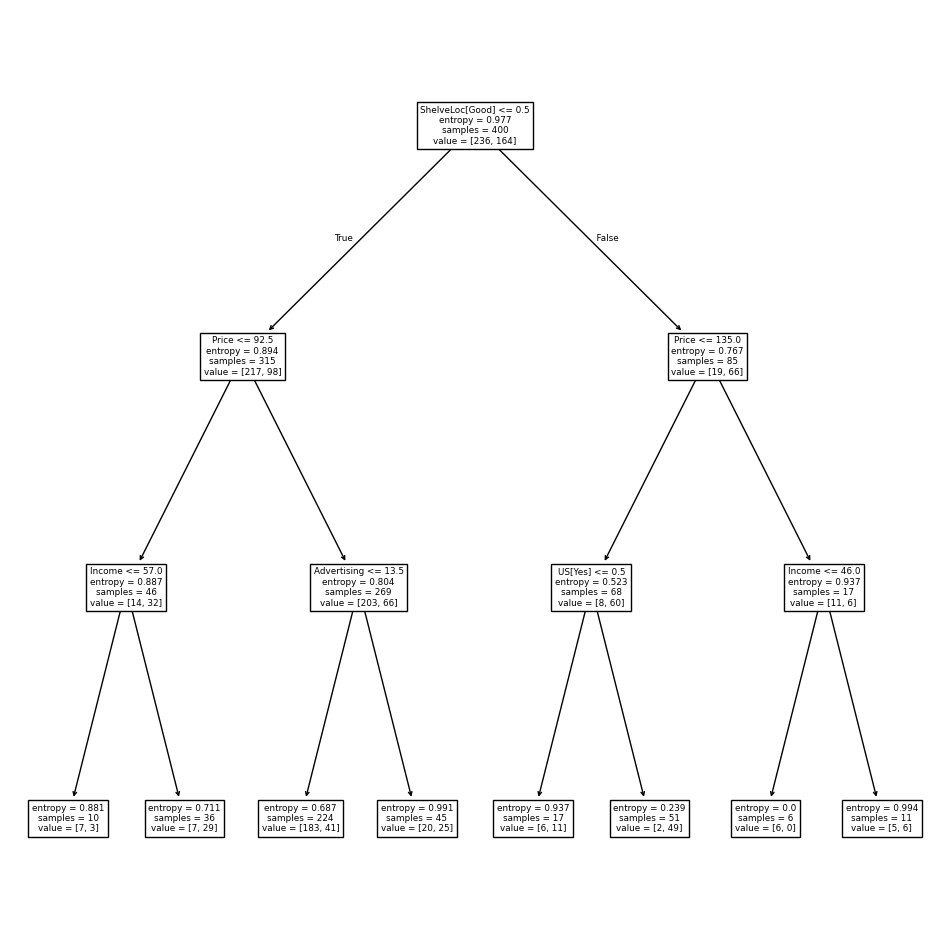

In [9]:
ax = subplots(figsize=(12,12))[1]
plot_tree(clf, feature_names=feature_names, ax=ax);

- The key indicator of `Sales` is `ShelveLoc`. 
- We can view a text representation of the tree with `export_text()`, which shows the split criteria (e.g., `Price <= 92.5`) for each branch and the overall prediction (`Yes` or `No`) at the leaf nodes.
- By using `show_weights=True`, we can also see the number of observations in each leaf that result in `Yes` and `No`.

In [10]:
print(export_text(clf, feature_names=feature_names,
                  show_weights=True))

|--- ShelveLoc[Good] <= 0.50
|   |--- Price <= 92.50
|   |   |--- Income <= 57.00
|   |   |   |--- weights: [7.00, 3.00] class: No
|   |   |--- Income >  57.00
|   |   |   |--- weights: [7.00, 29.00] class: Yes
|   |--- Price >  92.50
|   |   |--- Advertising <= 13.50
|   |   |   |--- weights: [183.00, 41.00] class: No
|   |   |--- Advertising >  13.50
|   |   |   |--- weights: [20.00, 25.00] class: Yes
|--- ShelveLoc[Good] >  0.50
|   |--- Price <= 135.00
|   |   |--- US[Yes] <= 0.50
|   |   |   |--- weights: [6.00, 11.00] class: Yes
|   |   |--- US[Yes] >  0.50
|   |   |   |--- weights: [2.00, 49.00] class: Yes
|   |--- Price >  135.00
|   |   |--- Income <= 46.00
|   |   |   |--- weights: [6.00, 0.00] class: No
|   |   |--- Income >  46.00
|   |   |   |--- weights: [5.00, 6.00] class: Yes



- To evaluate the performance of a classification tree, we estimate the test error instead of just the training error.
- We split the data into a training set to build the tree and then assess it on the test set, similar to the approach in the book.
- This procedure yields correct predictions for 68.5% of the locations in the test data set.

In [11]:
validation = skm.ShuffleSplit(n_splits=1, test_size=200, random_state=0)
results = skm.cross_validate(clf, D, High, cv=validation)
results['test_score']

array([0.685])

- Next, we evaluate if pruning the tree improves classification performance.
- We’ll split the data into training and test sets, use cross-validation to prune the tree on the training set, and then assess the pruned tree on the test set.

In [14]:
(X_train,X_test,High_train,High_test) = skm.train_test_split(
    X, High, test_size=0.5, random_state=0)                                   

- We first refit the full tree on the training set without setting a `max_depth` parameter, as we will determine that through cross-validation.

In [16]:
clf = DTC(criterion='entropy', random_state=0)
clf.fit(X_train, High_train)
accuracy_score(High_test, clf.predict(X_test))

0.735

- Next, we use `cost_complexity_pruning_path()` from `clf` to get the cost-complexity values.

In [17]:
ccp_path = clf.cost_complexity_pruning_path(X_train, High_train)
kfold = skm.KFold(10, random_state=1, shuffle=True)

- This provides impurities and $\alpha$ values that we can optimize using cross-validation.

In [18]:
grid = skm.GridSearchCV(clf, {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True, cv=kfold, scoring='accuracy')
grid.fit(X_train, High_train)
grid.best_score_

0.685

Let’s take a look at the pruned true.

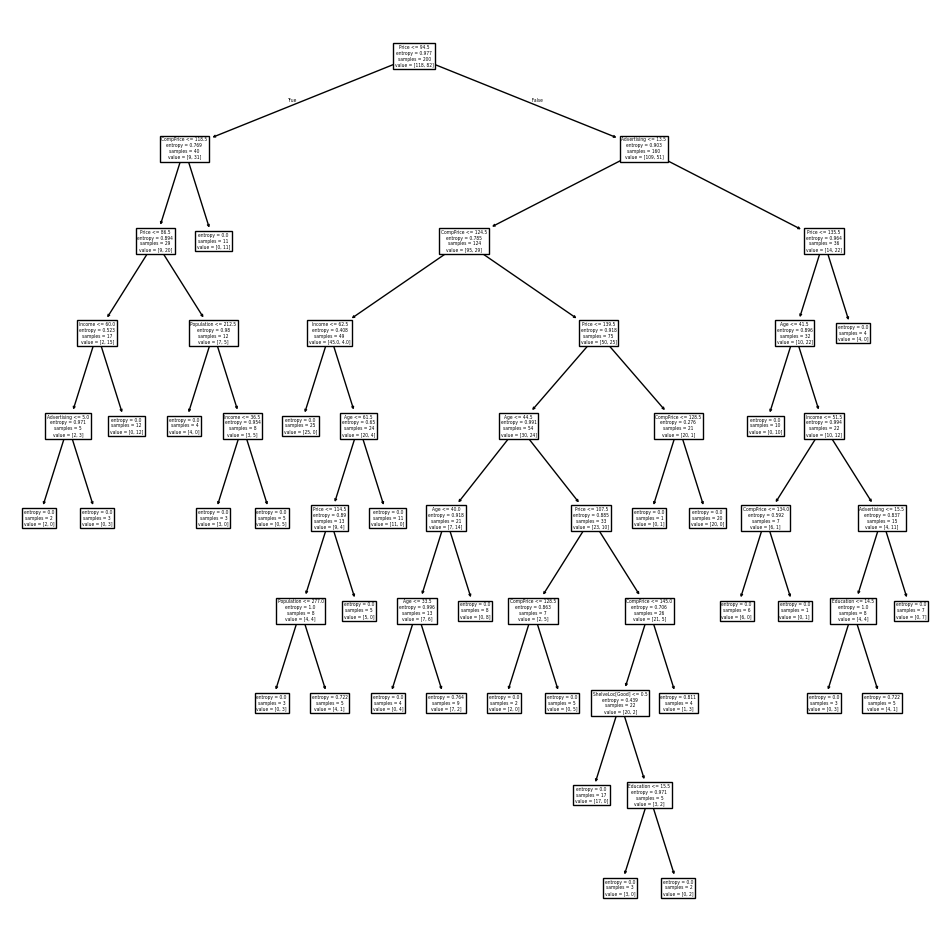

In [19]:
ax = subplots(figsize=(12, 12))[1]
best_ = grid.best_estimator_
plot_tree(best_, feature_names=feature_names, ax=ax);

This is quite a bushy tree. We could count the leaves, or query
`best_` instead.

In [20]:
best_.tree_.n_leaves

30

- The 30-terminal node tree has the lowest cross-validation error rate at 68.5% accuracy. We will assess its performance on the test data set using the `predict()` function.

In [21]:
print(accuracy_score(High_test, best_.predict(X_test)))
confusion = confusion_table(best_.predict(X_test), High_test)
confusion

0.72


Truth,No,Yes
Predicted,,
No,94,32
Yes,24,50


- Currently, 72.0% of test observations are correctly classified, slightly worse than the full tree with 35 leaves.
- Thus, cross-validation has not significantly improved results, pruning only 5 leaves at the cost of increased error.
- Results could vary with different random seeds, as cross-validation, while unbiased, has some variance.  